In [1]:
#!pip install keras
#!pip install tensorflow
#!pip install scikeras
#!pip install jupyter_contrib_nbextensions
#!jupyter contrib nbextension install --user

In [19]:
import csv
import itertools
import warnings
import nltk
import pandas as pd
import sklearn
import numpy as np
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.layers import Input, Dense, InputLayer, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
# from scikeras.wrappers import KerasClassifier
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.constraints import MaxNorm
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

warnings.filterwarnings(action='ignore')

In [3]:
def simplified_preprocessing(filename):
    header = ["train_id", "Sentence_1", "Sentence_2", "Output"]
    df = pd.read_csv(filename, sep='\t', names=header, engine='python', encoding='utf8', error_bad_lines=False,
                     quoting=csv.QUOTE_NONE)
    # Make all words lowercase
    df['Sentence_1'] = df['Sentence_1'].str.lower()
    df['Sentence_2'] = df['Sentence_2'].str.lower()

    return df


def bleu_score(sentence1array, sentence2array):
    features = pd.DataFrame(columns=["BLEU_1", "BLEU_2", "BLEU_3", "BLEU_4"])
    bleu1 = []
    bleu2 = []
    bleu3 = []
    bleu4 = []

    for (sentence_1, sentence_2) in itertools.zip_longest(sentence1array, sentence2array):
        first_sentence = nltk.word_tokenize(sentence_1)
        second_sentence = nltk.word_tokenize(sentence_2)
        bleu1.append(nltk.translate.bleu_score.sentence_bleu([first_sentence], second_sentence,
                                                             weights=[1]))
        bleu2.append(nltk.translate.bleu_score.sentence_bleu([first_sentence], second_sentence,
                                                             weights=[0.5, 0.5]))
        bleu3.append(nltk.translate.bleu_score.sentence_bleu([first_sentence], second_sentence,
                                                             weights=[1 / 3, 1 / 3, 1 / 3]))
        bleu4.append(nltk.translate.bleu_score.sentence_bleu([first_sentence], second_sentence,
                                                             weights=[1 / 4, 1 / 4, 1 / 4, 1 / 4]))

    features["BLEU_1"] = bleu1
    features["BLEU_2"] = bleu2
    features["BLEU_3"] = bleu3
    features["BLEU_4"] = bleu4

    return features


def meteor_scores(sentence1array, sentence2array):
    features = pd.DataFrame(columns=["METEOR"])

    meteor_score = []
    for (sentence_1, sentence_2) in itertools.zip_longest(sentence1array, sentence2array):
        first_sentence = nltk.word_tokenize(sentence_1)
        second_sentence = nltk.word_tokenize(sentence_2)
        meteor_score.append(nltk.translate.meteor_score.single_meteor_score(first_sentence, second_sentence))
    features["METEOR"] = meteor_score
    return features


def character_bigrams_features(sentence1array, sentence2array):
    features = pd.DataFrame(columns=["CharacterBigramUnion", "CharacterBigramIntersection",
                                     "NumCharBigrams1", "NumCharBigrams2",
                                     ])
    bigramUnion = []
    bigramIntersection = []
    numbigrams1 = []
    numbigrams2 = []

    for (sentence_1, sentence_2) in itertools.zip_longest(sentence1array, sentence2array):
        sentence_1_no_spaces = sentence_1.replace(" ", "")
        sentence_2_no_spaces = sentence_2.replace(" ", "")
        sentence_1_char_bigrams = [sentence_1_no_spaces[i:i + 2] for i in range(len(sentence_1_no_spaces) - 1)]
        sentence_2_char_bigrams = [sentence_2_no_spaces[i:i + 2] for i in range(len(sentence_2_no_spaces) - 1)]
        bigram_matches = 0
        for phrase in sentence_1_char_bigrams:
            if phrase in sentence_2_char_bigrams:
                bigram_matches += 1
        bigramIntersection.append(bigram_matches)
        bigramUnion.append(len(sentence_1_char_bigrams) + len(sentence_2_char_bigrams))
        numbigrams1.append(len(sentence_1_char_bigrams))
        numbigrams2.append(len(sentence_2_char_bigrams))
    features["CharacterBigramUnion"] = bigramUnion
    features["CharacterBigramIntersection"] = bigramIntersection
    features["NumCharBigrams1"] = numbigrams1
    features["NumCharBigrams2"] = numbigrams2

    return features


def word_unigram_features(sentence1array, sentence2array):
    features = pd.DataFrame(columns=["SentenceUnigramUnion", "SentenceUnigramIntersection",
                                     "NumSentUnigrams1", "NumSentUnigrams2"])
    unigramUnion = []
    unigramIntersection = []
    numunigrams1 = []
    numunigrams2 = []

    for (sentence_1, sentence_2) in itertools.zip_longest(sentence1array, sentence2array):
        sentence_1_words = nltk.word_tokenize(sentence_1)
        sentence_2_words = nltk.word_tokenize(sentence_2)
        sentence_1_unigrams = list(nltk.ngrams(sentence_1_words, 1))
        sentence_2_unigrams = list(nltk.ngrams(sentence_2_words, 1))
        unigram_matches = 0
        for phrase in sentence_1_unigrams:
            if phrase in sentence_2_unigrams:
                unigram_matches += 1
        unigramIntersection.append(unigram_matches)
        unigramUnion.append(len(sentence_1_unigrams) + len(sentence_2_unigrams))
        numunigrams1.append(len(sentence_1_unigrams))
        numunigrams2.append(len(sentence_2_unigrams))
    features["SentenceUnigramUnion"] = unigramUnion
    features["SentenceUnigramIntersection"] = unigramIntersection
    features["NumSentUnigrams1"] = numunigrams1
    features["NumSentUnigrams2"] = numunigrams2
    return features


def all_features(sentence1array, sentence2array):
    features = pd.DataFrame(columns=[
        "BLEU_1", "BLEU_2", "BLEU_3", "BLEU_4",
        "Meteor Score",
        "CharacterBigramUnion", "CharacterBigramIntersection", "NumCharBigrams1", "NumCharBigrams2",
        "SentenceUnigramUnion", "SentenceUnigramIntersection", "NumSentUnigrams1", "NumSentUnigrams2",
    ])
    bleu_scores = bleu_score(sentence1array, sentence2array)

    features["BLEU_1"] = bleu_scores["BLEU_1"]
    features["BLEU_2"] = bleu_scores["BLEU_2"]
    features["BLEU_3"] = bleu_scores["BLEU_3"]
    features["BLEU_4"] = bleu_scores["BLEU_4"]

    features["Meteor Score"] = meteor_scores(sentence1array, sentence2array)

    char_bigram = character_bigrams_features(sentence1array, sentence2array)
    word_unigram = word_unigram_features(sentence1array, sentence2array)

    features["CharacterBigramUnion"] = char_bigram["CharacterBigramUnion"]
    features["CharacterBigramIntersection"] = char_bigram["CharacterBigramIntersection"]
    features["NumCharBigrams1"] = char_bigram["NumCharBigrams1"]
    features["NumCharBigrams2"] = char_bigram["NumCharBigrams2"]

    features["SentenceUnigramUnion"] = word_unigram["SentenceUnigramUnion"]
    features["SentenceUnigramIntersection"] = word_unigram["SentenceUnigramIntersection"]
    features["NumSentUnigrams1"] = word_unigram["NumSentUnigrams1"]
    features["NumSentUnigrams2"] = word_unigram["NumSentUnigrams2"]

    return features


def get_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')  # don't have GPU
    return device


def df_to_tensor(df):
    device = get_device()
    return torch.from_numpy(df.values).float().to(device)

In [4]:
# nltk.download('punkt')
# nltk.download('wordnet')

In [5]:
training_data = simplified_preprocessing("train_with_label.txt")
X = all_features(training_data["Sentence_1"], training_data["Sentence_2"])
y = training_data["Output"]

dev_data = simplified_preprocessing("dev_with_label.txt")
Xdev = all_features(dev_data["Sentence_1"], dev_data["Sentence_2"])
ydev = dev_data["Output"]

In [20]:
def build_clf(unit):
  # creating the layers of the NN
  ann = tf.keras.models.Sequential()
  ann.add(InputLayer(input_shape=(13, )))
  ann.add(tf.keras.layers.Dense(32, activation='relu'))
  ann.add(Dropout(0.2))
  ann.add(tf.keras.layers.Dense(30, activation='relu', kernel_constraint=MaxNorm(3)))
  ann.add(Dropout(0.2))
  ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
  sgd = SGD(learning_rate=0.1, momentum=0.9)
  ann.compile(optimizer = sgd, loss = 'binary_crossentropy', metrics = ['accuracy'])
  return ann

In [29]:
# model=KerasClassifier(build_fn=build_clf)

params={'mlp__batch_size':[100, 20, 50, 25, 32], 
        'mlp__nb_epoch':[200, 100, 300, 400],
        'mlp__unit':[5,6, 10, 11, 12, 15],
           
        }

pipe = Pipeline(steps=[('std_scl', StandardScaler()),
                       ('mlp', KerasClassifier(build_fn=build_clf))])



# estimators = []
# estimators.append(('standardize', StandardScaler()))
# estimators.append(('mlp', KerasClassifier(build_fn =build_clf, nb_epoch=300, batch_size=16, unit=5)))
# pipeline = Pipeline(estimators)
# kfold = StratifiedKFold(n_splits=10, shuffle=True)
# results = cross_val_score(pipeline, X, y, cv=kfold)
# print("Hidden: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
# classifier.fit(X_train, y_train)
#gs=GridSearchCV(estimator=model, param_grid=params, cv=10)

gs = GridSearchCV(pipe, params)
# now fit the dataset to the GridSearchCV object. 
gs = gs.fit(X, y)

# kfold = StratifiedKFold(n_splits=10, shuffle=True)
# results = cross_val_score(pipeline, X, encoded_Y, cv=kfold)
# print("Hidden: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


16/16 [==============================] - 0s 2ms/step - loss: 0.1957 - accuracy: 0.9045


16/16 [==============================] - 0s 2ms/step - loss: 0.1974 - accuracy: 0.9000


312/312 [==============================] - 1s 2ms/step - loss: 0.2417 - accuracy: 0.8829


78/78 [==============================] - 1s 1ms/step - loss: 0.1886 - accuracy: 0.9064


313/313 [==============================] - 1s 2ms/step - loss: 0.2440 - accuracy: 0.8785


32/32 [==============================] - 0s 1ms/step - loss: 0.2088 - accuracy: 0.9006


125/125 [==============================] - 2s 2ms/step - loss: 0.2639 - accuracy: 0.8693


63/63 [==============================] - 0s 2ms/step - loss: 0.2316 - accuracy: 0.8942


250/250 [==============================] - 1s 2ms/step - loss: 0.2498 - accuracy: 0.8753


63/63 [==============================] - 0s 2ms/step - loss: 0.2047 - accuracy: 0.8885


196/196 [==============================] - 1s 2ms/step - loss: 0.2375 - accuracy: 0.8805


49/49 [==============================] - 0s 3ms/step - loss: 0.1882 - accuracy: 0.9103


157/157 [==============================] - 1s 2ms/step - loss: 0.2697 - accuracy: 0.8610


In [30]:
best_params=gs.best_params_
accuracy=gs.best_score_
print(best_params)
print(accuracy)
#print(gs.summary())

{'mlp__batch_size': 50, 'mlp__nb_epoch': 200, 'mlp__unit': 11}
0.9078328490257264


In [31]:
# test_acc = gs.score(Xdev, ydev)
# print("Test accuracy:", test_acc)
dev_predicted = gs.predict(Xdev)
print("Accuracy:", accuracy_score(ydev, dev_predicted))

125/125 [==============================] - 0s 1ms/step
Accuracy: 0.89


In [32]:
precision, recall, fscore, _ = precision_recall_fscore_support(ydev, dev_predicted,
                                                               average='binary')
print("Precision:", np.round(precision, 2))
print("Recall:", np.round(recall, 2))
# print("F-Score:", np.round(fscore, 2))


Precision: 0.71
Recall: 0.94


In [33]:
print("Macro f1 score: ",f1_score(ydev, dev_predicted, average='macro'))
print("Micro f1 score: ",f1_score(ydev, dev_predicted, average='micro'))
print("Weighted f1 score: ",f1_score(ydev, dev_predicted, average='weighted'))

Macro f1 score:  0.8665759383047139
Micro f1 score:  0.89
Weighted f1 score:  0.8945282792298763



Confusion Matrix


Text(33.0, 0.5, 'True')

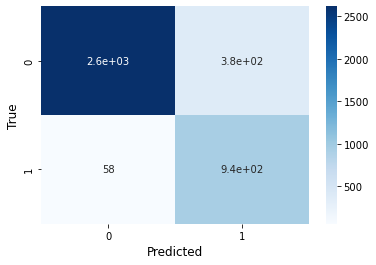

In [34]:
cf_matrix = confusion_matrix(ydev, dev_predicted)
print("\nConfusion Matrix")
sns.heatmap(cf_matrix, annot=True, cmap='Blues')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)

In [35]:
def test_preprocess(filename):
    header = ["test_id", "Sentence_1", "Sentence_2"]
    df = pd.read_csv(filename, quoting=3, encoding='utf8', error_bad_lines=False, names=header,
                     sep='\t')
    # Make all words lowercase
    df['Sentence_1'] = df['Sentence_1'].str.lower()
    df['Sentence_2'] = df['Sentence_2'].str.lower()
    return df

In [36]:
# test_data = test_preprocess("test_without_label.txt")
# Xtest = all_features(test_data["Sentence_1"], test_data["Sentence_2"])
# Xoutput = pd.DataFrame()
# Xoutput['test_id'] = test_data["test_id"]
# Xoutput['prediction'] = gs.predict(Xtest)
# Xoutput.to_csv("OwenFitzgeraldKing_test_result.txt", sep='\t', index=False, header=False)


125/125 [==============================] - 0s 1ms/step
